In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
#Upload Data From CSV to dataframe
data = pd.read_csv("data2.csv")
data.head()

,subject_id,admission_type,insurance,los_hospital,anchor_age,glucose_mean,heart_rate_mean,sbp_mean,dbp_mean,mbp_mean,...,mild_liver_disease,diabetes_without_cc,paraplegia,malignant_cancer,severe_liver_disease,metastatic_solid_tumor,aids,sepsis3,total_urine_output,AKI
0,13248510,URGENT,Private,3,19,89.300000,79.814815,151.468085,87.957447,107.468085,...,0,0,0,0,1,0,0,NaN,13635.0,1
1,15680483,EW EMER.,Private,4,21,179.000000,78.160000,108.538462,53.076923,65.615385,...,0,1,0,0,0,0,0,True,9170.0,1
2,12832775,URGENT,Medicaid,71,22,138.818182,94.645833,111.126316,53.647368,70.752632,...,0,1,0,0,0,0,0,True,451921.0,1
3,12832775,URGENT,Medicaid,71,22,201.807692,116.607143,135.560000,67.920000,81.920000,...,0,1,0,0,0,0,0,NaN,20750.0,1
4,10810063,URGENT,Private,8,22,122.400000,90.527778,113.385714,71.028571,86.157143,...,1,0,0,0,0,0,0,True,65130.0,1


In [3]:
# Drop the columns with more than 20% missing values
threshold = 0.2
missing_percentage = data.isnull().sum() / len(data)
filtered_data = data.loc[:, missing_percentage <= threshold]

In [4]:
# Split the data into train and test
categorical_cols = filtered_data.select_dtypes(include=['object']).columns
numerical_cols = filtered_data.select_dtypes(exclude=['object']).columns

In [5]:
#Label Encoding for categorical columns and impute missing values for numerical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
    label_encoders[col] = le
imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data_numerical = pd.DataFrame(imputer.fit_transform(filtered_data[numerical_cols]), columns=numerical_cols)
imputed_data = pd.concat([imputed_data_numerical, filtered_data[categorical_cols]], axis=1)

C:\Users\eric9\AppData\Local\Temp\ipykernel_42748\3064761086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
C:\Users\eric9\AppData\Local\Temp\ipykernel_42748\3064761086.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))


In [6]:
X = imputed_data.drop('AKI', axis=1)
y = imputed_data['AKI']

In [7]:
# Lasso Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Assuming `X` is your feature matrix and `y` is your target variable
lasso = Lasso(alpha=0.01, random_state=42)  # Adjust alpha as needed
lasso.fit(X, y)

# Use SelectFromModel to select important features
model = SelectFromModel(lasso, prefit=True)
X_selected = model.transform(X)

# Get the selected feature names
selected_features = X.columns[(model.get_support())]
print("Selected Features:", selected_features)

Selected Features: Index(['los_hospital', 'anchor_age', 'glucose_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'hematocrit_max', 'wbc_max', 'bicarbonate_max', 'bun_max',
       'calcium_max', 'chloride_max', 'creatinine_max', 'glucose_max',
       'sodium_max', 'pt_max', 'ptt_max', 'alt_max', 'bilirubin_total_max',
       'admission_type', 'insurance'],
      dtype='object')


C:\Users\eric9\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [8]:
print(selected_features)

Index(['los_hospital', 'anchor_age', 'glucose_mean', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean', 'spo2_mean',
       'hematocrit_max', 'wbc_max', 'bicarbonate_max', 'bun_max',
       'calcium_max', 'chloride_max', 'creatinine_max', 'glucose_max',
       'sodium_max', 'pt_max', 'ptt_max', 'alt_max', 'bilirubin_total_max',
       'admission_type', 'insurance'],
      dtype='object')


In [9]:
# Identify the target column
X = X[selected_features]  
y = imputed_data['AKI']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [11]:
# Build the Neural Network
model = Sequential()
# Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
# Hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))
# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# Train the Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50


C:\Users\eric9\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7696 - loss: 0.5407 - val_accuracy: 0.8026 - val_loss: 0.4282
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8033 - loss: 0.4281 - val_accuracy: 0.8026 - val_loss: 0.4061
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8184 - loss: 0.3913 - val_accuracy: 0.8092 - val_loss: 0.3924
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8171 - loss: 0.3833 - val_accuracy: 0.8026 - val_loss: 0.3835
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8058 - loss: 0.4116 - val_accuracy: 0.8092 - val_loss: 0.3737
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.3430 - val_accuracy: 0.8026 - val_loss: 0.3765
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8368 - loss: 0.3450 - val_accuracy: 0.8355 - val_loss: 0.3725
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8193 - loss: 0.3503 - val_accuracy: 0.8158 - val_loss: 0.3806
Ep

In [12]:
# Predict the test data
y_pred_prob_nn = model.predict(X_test).flatten()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [13]:
# Evaluating the neural network model
auc_nn = roc_auc_score(y_test, y_pred_prob_nn)
print(f"Neural Network AUC Score: {auc_nn}")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))
print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

Neural Network AUC Score: 0.864943423647877
Neural Network Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.71      0.65        78
         1.0       0.90      0.85      0.88       247

    accuracy                           0.82       325
   macro avg       0.75      0.78      0.76       325
weighted avg       0.83      0.82      0.82       325

Neural Network Confusion Matrix:
[[ 55  23]
 [ 36 211]]


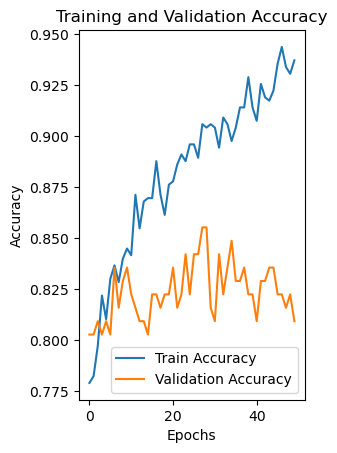

In [14]:
# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()